**Table of contents**<a id='toc0_'></a>    
- [Playbook: What is Softmax and Derivatives](#toc1_)    
- [Playbook: Sampling Methodologies in Large Language Models](#toc2_)    
  - [Sampling Methodologies (Deep Learning: Foundations and Concepts)](#toc2_1_)    
  - [Order Preservation in Softmax](#toc2_2_)    
  - [Sharpness of Softmax Distribution](#toc2_3_)    
  - [Multinomial](#toc2_4_)    
  - [Greedy vs Probabilistic sampling](#toc2_5_)    
  - [Conclusion](#toc2_6_)    
  - [Multinomial Distribution](#toc2_7_)    
  - [Formalizing Multinomial Sampling](#toc2_8_)    
  - [Impact of Temperature on Multinomial Sampling](#toc2_9_)    
  - [Example in Sequence Generation](#toc2_10_)    
- [Why Do We Like To Use Warmup and Cosine Schedulers?](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Playbook: What is Softmax and Derivatives](#toc0_)

In [8]:
from __future__ import annotations
from torch import nn
import torch
import torch.nn.functional as F
from rich.pretty import pprint
from typing import List, Dict, Any, Optional

class Softmax:
    """
    Softmax activation function.
    """

    def __init__(self, dim: int | None = None) -> None:
        """
        Initialize the softmax function.
        """
        self.dim = dim

    def __call__(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the softmax function for a given input.
        """
        numerator = torch.exp(z)
        denominator = torch.sum(numerator, dim=self.dim, keepdim=True)
        g = numerator / denominator
        return g


    def gradient(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the derivative of the softmax function with respect to its input.
        """
        g = self.__call__(z)
        g = g.unsqueeze(-1)  # add an extra dimension
        eye = torch.eye(g.shape[1], device=z.device)[None, :]  # identity matrix
        dg_dz = g * (eye - g)
        return dg_dz.sum(dim=1)


z = torch.randn((2, 5), requires_grad=True, dtype=torch.float32)
pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_outputs = pytorch_softmax(z)
pprint(pytorch_softmax_outputs)

my_softmax = Softmax(dim=1)
my_softmax_outputs = my_softmax(z)
pprint(my_softmax_outputs)

torch.testing.assert_close(
    pytorch_softmax_outputs, my_softmax_outputs, rtol=1.3e-6, atol=1e-5, msg="Softmax function outputs do not match."
)

tensor([[0.3400, 0.0411, 0.0217, 0.5727, 0.0246],
│   │   [0.0656, 0.0864, 0.1489, 0.2467, 0.4524]], grad_fn=<SoftmaxBackward0>)

tensor([[0.3400, 0.0411, 0.0217, 0.5727, 0.0246],
│   │   [0.0656, 0.0864, 0.1489, 0.2467, 0.4524]], grad_fn=<DivBackward0>)

In [ ]:
z = torch.randn((2, 5), requires_grad=True)
pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_outputs = pytorch_softmax(z)


In [13]:
# Use PyTorch's softmax and calculate gradients with respect to z
output_torch = F.softmax(z, dim=1)
loss_torch = output_torch.log().mean()  # Example loss for gradient calculation
loss_torch.backward()

# Gradients obtained via PyTorch
gradients_torch = z.grad.data

# Reset gradients in z for custom gradient computation
z.grad = None

# Compute softmax using custom function and calculate custom gradients
softmax = Softmax()
output_custom = softmax(z)
# For custom gradient calculation, we need an illustrative "loss" since gradients are usually
# calculated in the context of some scalar output. Here, we mimic a simple operation as a stand-in for loss.
loss_custom = output_custom.log().mean()
loss_custom.backward()

# Assuming custom gradient computation inside the backward method of a custom autograd function,
# here we manually compute it for comparison, which isn't directly applicable as is.
# gradients_custom = softmax.gradient(z)  # This line was proposed, but doesn't fit directly into the autograd framework as is.

# Print both gradients for comparison
print("Gradients via PyTorch's autograd:")
print(gradients_torch)
print("\nManual gradient computation currently doesn't integrate directly with autograd; needs adjustment.")
# Print the manually computed gradients for educational purposes, if applicable
# print("\nCustom computed gradients (for illustration, not directly comparable):")
# print(gradients_custom)

Gradients via PyTorch's autograd:
tensor([[-0.0172,  0.0806,  0.0072, -0.0803,  0.0096],
        [ 0.0730,  0.0435, -0.0768, -0.0686,  0.0288]])

Manual gradient computation currently doesn't integrate directly with autograd; needs adjustment.


In [10]:
# get gradients of nn.Softmax

z.requires_grad = True
z.retain_grad()
pytorch_softmax_outputs = pytorch_softmax(z)
pytorch_softmax_outputs.sum().backward()
print("PyTorch Softmax Gradient:", z.grad)

PyTorch Softmax Gradient: tensor([[-4.3086e-08, -5.9735e-09, -1.9813e-08, -2.2872e-08, -3.0181e-09,
         -5.1731e-08, -3.5311e-08, -1.6718e-08, -3.0283e-08, -9.6135e-09],
        [ 2.3789e-09,  8.6295e-09,  1.4517e-09,  1.9518e-08,  5.1734e-09,
          1.1618e-09,  1.5833e-08,  3.6878e-08,  1.0539e-08,  1.7647e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


In [8]:
my_softmax.gradient(z)

tensor([[ 0.0395, -0.1162, -0.0581, -0.0453, -0.1286,  0.0757,  0.0069, -0.0711,
         -0.0142, -0.1009],
        [-0.1577, -0.1052, -0.1655, -0.0139, -0.1342, -0.1679, -0.0448,  0.1317,
         -0.0892, -0.0296],
        [ 0.0880, -0.0337, -0.0529, -0.0826, -0.0171, -0.1002, -0.1225, -0.1121,
          0.0509, -0.0456],
        [-0.1719, -0.2328, -0.1720, -0.2228, -0.2369, -0.2246,  0.0033, -0.1809,
         -0.2363,  0.1562],
        [-0.1041,  0.0046, -0.1296, -0.0668, -0.0869, -0.0171, -0.0134,  0.0384,
         -0.0435,  0.0653]], grad_fn=<SumBackward1>)

# <a id='toc2_'></a>[Playbook: Sampling Methodologies in Large Language Models](#toc0_)

## <a id='toc2_1_'></a>[Sampling Methodologies (Deep Learning: Foundations and Concepts)](#toc0_)

We have seen that the output of a decoder transformer is a probability
distribution over values for the next token in the sequence, from which a
particular value for that token must be chosen to extend the sequence. There are
several options for selecting the value of the token based on the computed
probabilities (Holtzman et al., 2019). One obvious approach, called greedy
search, is simply to select the token with the highest probability. This has the
effect of making the model deterministic, in that a given input sequence always
generates the same output sequence. Note that simply choosing the highest
probability token at each stage is not the same as selecting the highest
probability sequence of tokens. To find the most probable sequence, we would
need to maximize the joint distribution over all tokens, which is given by

$$
p\left(\mathbf{y}_1, \ldots, \mathbf{y}_N\right)=\prod_{n=1}^N p\left(\mathbf{y}_n \mid \mathbf{y}_1, \ldots, \mathbf{y}_{n-1}\right)
$$

If there are $N$ steps in the sequence and the number of token values in the
dictionary is $K$ then the total number of sequences is
$\mathcal{O}\left(K^N\right)$, which grows exponentially with the length of the
sequence, and hence finding the single most probable sequence is infeasible. By
comparison, greedy search has cost $\mathcal{O}(K N)$, which is linear in the
sequence length.

One technique that has the potential to generate higher probability sequences
than greedy search is called beam search. Instead of choosing the single most
probable token value at each step, we maintain a set of $B$ hypotheses, where
$B$ is called the beam width, each consisting of a sequence of token values up
to step $n$. We then feed all these sequences through the network, and for each
sequence we find the $B$ most probable token values, thereby creating $B^2$
possible hypotheses for the extended sequence. This list is then pruned by
selecting the most probable $B$ hypotheses according to the total probability of
the extended sequence. Thus, the beam search algorithm maintains $B$ alternative
sequences and keeps track of their probabilities, finally selecting the most
probable sequence amongst those considered. Because the probability of a
sequence is obtained by multiplying the probabilities at each step of the
sequence and since these probability are always less than or equal to one, a
long sequence will generally have a lower probability than a short one, biasing
the results towards short sequences. For this reason the sequence probabilities
are generally normalized by the corresponding lengths of the sequence before
making comparisons. Beam search has cost $\mathcal{O}(B K N)$, which is again
linear in the sequence length. However, the cost of generating a sequence is
increased by a factor of $B$, and so for very large language models, where the
cost of inference can become significant, this makes beam search much less
attractive.

One problem with approaches such as greedy search and beam search is that they
limit the diversity of potential outputs and can even cause the generation
process to become stuck in a loop, where the same sub-sequence of words is
repeated over and over. As can be seen in Figure 12.17, human-generated text may
have lower probability and hence be more surprising with respect to a given
model than automatically generated text.

Instead of trying to find a sequence with the highest probability, we can
instead generate successive tokens simply by sampling from the softmax
distribution at each step. However, this can lead to sequences that are
nonsensical. This arises from the typically very large size of the token
dictionary, in which there is a long tail of many token states each of which has
a very small probability but which in aggregate account for a significant
fraction of the total probability mass. This leads to the problem in which there
is a significant chance that the system will make a bad choice for the next
token.

As a balance between these extremes, we can consider only the states having the
top $K$ probabilities, for some choice of $K$, and then sample from these
according to their renormalized probabilities. A variant of this approach,
called top- $p$ sampling or nucleus sampling, calculates the cumulative
probability of the top outputs until a threshold is reached and then samples
from this restricted set of token states.

A 'softer' version of top- $K$ sampling is to introduce a parameter $T$ called
temperature into the definition of the softmax function (Hinton, Vinyals, and
Dean, 2015) so that

$$
y_i=\frac{\exp \left(a_i / T\right)}{\sum_j \exp \left(a_j / T\right)}
$$

and then sample the next token from this modified distribution. When $T=0$, the
probability mass is concentrated on the most probable state, with all other
states having zero probability, and hence this becomes greedy selection. For
$T=1$, we recover the unmodified softmax distribution, and as
$T \rightarrow \infty$, the distribution becomes uniform across all states. By
choosing a value in the range $0<T<1$, the probability is concentrated towards
the higher values.

One challenge with sequence generation is that during the learning phase, the
model is trained on a human-generated input sequence, whereas when it is running
generatively, the input sequence is itself generated from the model. This means
that the model can drift away from the distribution of sequences seen during
training.



## <a id='toc2_2_'></a>[Order Preservation in Softmax](#toc0_)

See softmax playbook

## <a id='toc2_3_'></a>[Sharpness of Softmax Distribution](#toc0_)

See softmax playbook

## <a id='toc2_4_'></a>[Multinomial](#toc0_)

In multinomial (or probabilistic) sampling, the model samples from the entire
probability distribution obtained after applying softmax:

At higher temperatures, the probability distribution becomes more uniform,
increasing the likelihood of sampling less probable tokens, thereby introducing
more randomness or diversity into the selection process. At lower temperatures,
the distribution becomes sharper, concentrating most of the probability mass on
a few high-probability tokens. This makes the selection less random and more
predictable, closely aligning with the greedy selection outcome but still
allowing for some variability.

KEY is to understand multinomial in the sampling.

## <a id='toc2_5_'></a>[Greedy vs Probabilistic sampling](#toc0_)

If your model employs a greedy strategy for selecting tokens (e.g., always
choosing the token with the highest probability), then adjusting the temperature
won't change the selected token. This approach is common in tasks where
precision is critical, and the aim is to reduce randomness to a minimum, such as
in certain classification tasks or when generating text where maximum coherence
is desired.

In [10]:
import torch
from typing import List
from rich.pretty import pprint

In [3]:
def demonstrate_multinomial_sampling_effect(logits: torch.Tensor, temperatures: List[float], epsilon: float = 1e-8):
    """
    Demonstrates the effect of temperature on multinomial sampling from the softmax distribution.

    Args:
        logits (torch.Tensor): The input logits.
        temperatures (list): A list of temperatures to apply.
        num_samples (int): The number of samples to draw from the distribution.

    Returns:
        dict: A dictionary mapping each temperature to its corresponding sampled outcomes.
    """
    softmax_results = {}
    sampling_results = {}
    for temperature in temperatures:
        scaled_logits = logits / (temperature + epsilon)  # Scale logits by temperature
        probs = torch.softmax(scaled_logits, dim=-1)  # Apply softmax to scaled logits
        samples = torch.multinomial(probs, num_samples=1, replacement=False)
        softmax_results[temperature] = probs.numpy()
        sampling_results[temperature] = samples.numpy()
    return softmax_results, sampling_results

1 - preserve order show it in code
2 - sample more times to show effect - distribution count for each 

In [16]:
# Example logits
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])

# Temperatures to explore
temperatures = [0.1, 1.0, 10.0]

# Generate samples under different temperatures
softmax_distributions, sampling_distributions = demonstrate_multinomial_sampling_effect(logits, temperatures)

pprint(softmax_distributions)
pprint(sampling_distributions)

{
│   0.1: array([1.9286696e-22, 4.2481610e-18, 9.3572157e-14, 2.0610600e-09,
│      4.5397868e-05, 9.9995458e-01], dtype=float32),
│   1.0: array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.233122  ,
│      0.6336913 ], dtype=float32),
│   10.0: array([0.12792668, 0.14138085, 0.15624999, 0.17268294, 0.19084416,
│      0.21091543], dtype=float32)
}

{0.1: array([5]), 1.0: array([5]), 10.0: array([4])}

In [18]:
logits

tensor([1., 2., 3., 4., 5., 6.])

Here's how the softmax distribution changes with different temperatures for the
given logits `[1.0, 2.0, 3.0]`:

-   **Temperature = 0.1**: The softmax probabilities are approximately
    `[2.06e-09, 4.54e-05, 0.9999]`. At this low temperature, the distribution
    becomes extremely "sharp," where the highest logit (3.0) dominates, and its
    probability is almost 1. This demonstrates the effect of low temperatures in
    making the softmax output more deterministic, favoring the highest logit
    significantly over the others.

-   **Temperature = 1.0** (no scaling): The softmax probabilities are
    `[0.09, 0.24, 0.67]`. This is the standard softmax distribution without any
    temperature scaling. The highest logit still has the highest probability,
    but the distribution is less skewed than at lower temperatures, allowing for
    some level of variability in sampling.

-   **Temperature = 10.0**: The softmax probabilities are `[0.30, 0.33, 0.37]`.
    At this high temperature, the distribution becomes much "softer," and the
    probabilities are closer to each other, making the outcome more uniform.
    This indicates increased randomness in sampling, as the differences between
    the logits are dampened, making it less predictable which token will be
    sampled.

## <a id='toc2_6_'></a>[Conclusion](#toc0_)

-   **Low temperatures** sharpen the softmax distribution, increasing the
    probability of the highest logit significantly and making the model's output
    more predictable.

-   **High temperatures** soften the softmax distribution, equalizing the
    probabilities and introducing more randomness into the model's output.

This demonstrates the practical effect of temperature on the behavior of softmax
and, by extension, on the sampling strategy used in generative models.

To cater to a mathematical audience, let's delve deeper into the formal
definition of multinomial sampling and its connection to temperature-scaled
softmax distributions in the context of sequence generation models.

## <a id='toc2_7_'></a>[Multinomial Distribution](#toc0_)

The multinomial distribution is a generalization of the binomial distribution.
It models the probabilities of observing counts among multiple categories and is
parametrized by probabilities $\pi_1, \pi_2, \ldots, \pi_n$ corresponding to $n$
outcomes. These probabilities must satisfy two conditions:

1. $0 \leq \pi_i \leq 1$ for all $i$,
2. $\sum\_{i=1}^{n} \pi_i = 1$.

Given a single trial, the probability of outcome $i$ occurring is $\pi_i$. When
sampling from a multinomial distribution, each sample (or draw) is independent,
and the probability of observing a specific outcome follows the distribution
defined by $\pi$.

## <a id='toc2_8_'></a>[Formalizing Multinomial Sampling](#toc0_)

In the context of generative models, after computing the softmax distribution
over the logits (or scores) $z_i$ for each token $i$ in the vocabulary, the
softmax function at temperature $T$ is applied to obtain probabilities:

$$p*i = \frac{\exp(z_i / T)}{\sum*{j=1}^{n} \exp(z_j / T)}$$

Here, $p_i$ represents the probability of selecting token $i$ as the next token
in the sequence, forming a probability distribution
$\pi = [p_1, p_2,
\ldots, p_n]$ over the vocabulary.

Given $\pi$, multinomial sampling draws a sample $s$ where $P(s=i) = p_i$. This
process can be repeated to generate sequences of tokens.

## <a id='toc2_9_'></a>[Impact of Temperature on Multinomial Sampling](#toc0_)

The temperature parameter $T$ modulates the sharpness of the probability
distribution $\pi$:

-   **For $T < 1$**, the distribution becomes sharper, with a higher probability
    concentrated on the tokens with the highest logits. This makes the sampling
    process more deterministic, as the variance among the probabilities is
    increased, favoring the selection of the most likely token.

-   **For $T = 1$**, the distribution is exactly the softmax of the logits,
    representing the model's learned probabilities without modification.

-   **For $T > 1$**, the distribution becomes flatter, making less likely tokens
    more probable to be selected. This introduces more randomness into the
    sampling process, as the variance among the probabilities is decreased.

## <a id='toc2_10_'></a>[Example in Sequence Generation](#toc0_)

Consider generating text from a model trained on a large corpus. At each step,
the model outputs logits, which are transformed into probabilities $\pi$ using
the softmax function scaled by temperature $T$. Multinomial sampling is then
used to select the next token from these probabilities. Adjusting $T$ allows
controlling the randomness and diversity of the generated text: lower $T$ favors
more predictable text closely following the training data, while higher $T$
favors more novel and varied sequences.

This formal treatment of multinomial sampling and temperature's role offers a
nuanced understanding of how generative models like GPT navigate the trade-offs
between diversity and fidelity in sequence generation.


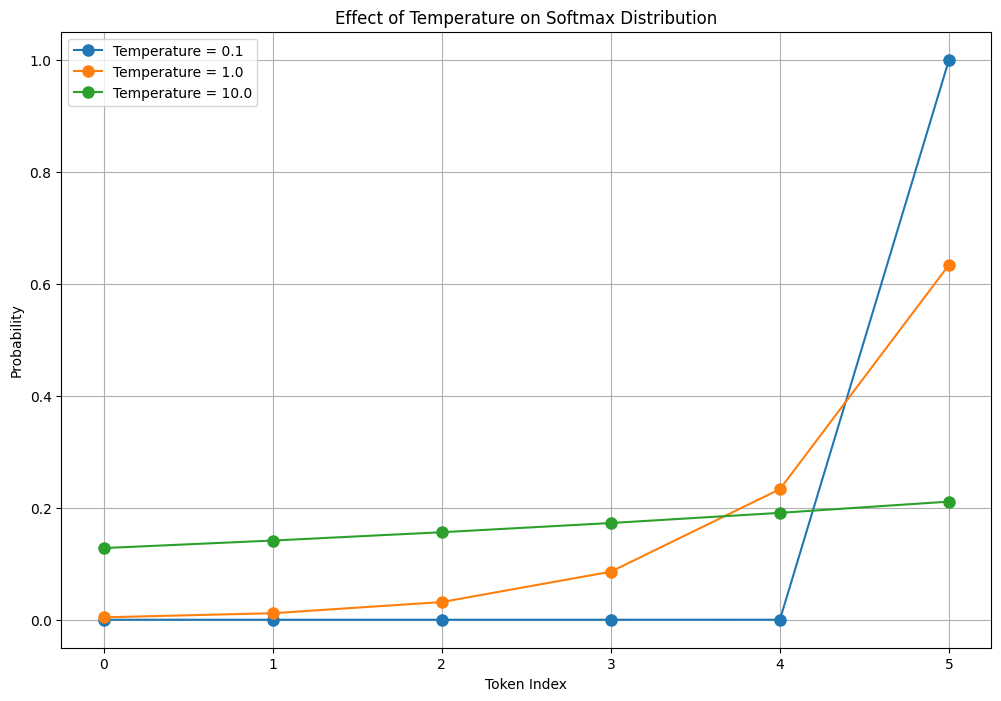

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(logits, temperature=1.0):
    """Compute softmax values for each set of logits in x."""
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # for numerical stability
    return exp_logits / np.sum(exp_logits)

plt.figure(figsize=(12, 8))

logits = logits.numpy()

for temp in temperatures:
    probs = softmax(logits, temperature=temp)
    plt.plot(probs, label=f'Temperature = {temp}', marker='o', linestyle='-', markersize=8)

plt.title('Effect of Temperature on Softmax Distribution')
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.xticks(range(len(logits)))
plt.legend()
plt.grid(True)
plt.show()


# <a id='toc3_'></a>[Why Do We Like To Use Warmup and Cosine Schedulers?](#toc0_)

# How to Derive Sigmoid and Softmax Functions from Exponential Family in Machine Learning Context

REFERENCE:

-   6.2.2.2, 6.2.2.3 of The Deep Learning Book by Goodfellow et al.
-   3.4. of Deep Learning: Foundations and Concepts by Bishop et al.

SAMPLE CONTENT BELOW (TO BE REFINED): We can derive via exponential family.

## Bernoulli Distribution as an Exponential Family Member

The Bernoulli distribution can be expressed in the exponential family form as
follows:

$$
p(y | \eta) = b(y) \exp(\eta^T y - A(\eta))
$$

For the Bernoulli distribution:

-   $y$ is the binary outcome (0 or 1).
-   $\eta$ (or $\theta$ in some formulations) is the natural parameter of the
    distribution.
-   The base measure $b(y) = 1$, since it doesn't affect the form of the
    Bernoulli distribution.
-   The sufficient statistic $y$ is the identity function of the outcome.

To match the Bernoulli distribution to the exponential family form, we recognize
that $p(y | \eta)$ for $y \in \{0,1\}$ is given by
$p(y = 1 | \eta) =
\sigma(\eta)$ and $p(y = 0 | \eta) = 1 - \sigma(\eta)$, where
$\sigma(\eta)$ is the sigmoid function. The Bernoulli distribution can be
written as:

$$
p(y | \eta) = \sigma(\eta)^y (1 - \sigma(\eta))^{1-y}
$$

## Expressing Bernoulli in Exponential Family Form

Let's express the Bernoulli distribution in the form that highlights the
exponential family structure. To do this, note that the probability of success
$p = \sigma(\eta)$ where $\sigma(\eta)$ is the sigmoid function. By definition:

$$
\sigma(\eta) = \frac{1}{1 + e^{-\eta}}
$$

So, we have:

$$
p(y | \eta) = \frac{e^{\eta y}}{1 + e^{\eta}}
$$

where the natural parameter $\eta = \log\left(\frac{p}{1-p}\right)$, and
$A(\eta) = -\log(1 - p) = \log(1 + e^{\eta})$.

## Derivation of the Sigmoid Function

The sigmoid function is derived as the transformation of the natural parameter
$\eta$ back to the probability $p$. From the natural parameter, we have
$\eta = \log\left(\frac{p}{1-p}\right)$, solving for $p$ gives us the sigmoid
function:

$$
\eta = \log\left(\frac{p}{1-p}\right) \Rightarrow e^{\eta} = \frac{p}{1-p} \Rightarrow p = \frac{e^{\eta}}{1 + e^{\eta}}
$$

By substituting $\eta$ back with a linear combination of features (e.g.,
$z =
\boldsymbol{w}^\top \boldsymbol{x} + b$ in machine learning), we obtain the
sigmoid function used for binary classification:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In this manner, the sigmoid function is derived as a special case of applying
the exponential family formulation to the Bernoulli distribution, with the
natural parameter $\eta$ serving as the link between the linear predictor and
the probabilities of the outcomes.
